In [1]:
import matplotlib,aplpy,numpy,astropy,glob,os
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astropy.table import QTable, Table
from astropy import units
import aplpy

In [2]:
font = {'size'   : 14, 'family' : 'serif', 'serif' : 'cm'}
plt.rc('font', **font)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1

In [3]:
c = 299792.458 #km/s
#HI line rest frequency
f0 = 1.420405751 #GHz
#Hubble constant
H0 = 70. #km/s/Mpc
h = H0/100.
#Solar mass
Msol = 1.99E30 #kg
#Proton mass
mp = 1.67E-27 #kg
#Parsec
pc = 3.086E16 #m

In [4]:
def v_rad(v_opt):
    '''
    Conversion from optical to radio velocity.
    
    Inputs:
        v_opt: Optical velocity [km/s].
        
    Outputs:
        v_rad: Radio velocity [km/s].
    '''
    
    return c*(1. - (1./(1.+(v_opt/c))))

def v_opt(v_rad):
    '''
    Conversion from radio to optical velocity.
    
    Inputs:
        v_rad: Radio velocity [km/s].
        
    Outputs:
        v_opt: Optical velocity [km/s].
    '''
    
    return c*((1./(1.-(v_rad/c))) - 1.)

def read_fitscube(filename,need_beam=False,widths=False,mask=False,verbose=False):
    '''
    Reads a fits cube that is RA, Dec, Vel and builds the axes.
    
    Inputs:
        filename = String indicating the full location of the fits file.
        need_beam = Boolean indicating whether to return beam dimensions.
        widths = Boolean indicating whether to return axes step sizes.
        verbose = Boolean indicating whether to print all output.
        
    Outputs:
        cube = The data values from the fits file.
        cube_ra = Right ascension axis values [deg].
        cube_dec = Declination axis values [deg].
        cube_vel = Velocity axis values [km/s].
        bmaj = (if need_beam) Beam major axis diameter [arcsec].
        bmin = (if need_beam) Beam major axis diameter [arcsec].
        pa = (if need_beam) Beam position angle [deg].
        beam_factor = (if need_beam) Ratio of beam area to pixel area.
        cube_dx = (if widths) RA axis step size [deg].
        cube_dy = (if widths) Dec axis step size [deg].
        cube_dv = (if widths) Velocity axis step size [km/s].
    '''
    
    cube_fits = astropy.io.fits.open(filename)

    cube = cube_fits[0].data
    cube_head = cube_fits[0].header

    cube_dx = cube_head['CDELT1']
    cube_dy = cube_head['CDELT2']
    cube_dv = cube_head['CDELT3']

    cube_ra = cube_head['CRVAL1'] + cube_dx * numpy.arange(1,1+cube_head['NAXIS1']) - cube_dx * cube_head['CRPIX1'] # RA
    cube_dec = cube_head['CRVAL2'] + cube_dy * numpy.arange(1,1+cube_head['NAXIS2']) - cube_dy * cube_head['CRPIX2'] # Dec
    cube_vel = cube_head['CRVAL3'] + cube_dv * numpy.arange(1,1+cube_head['NAXIS3']) - cube_dv * cube_head['CRPIX3']

    if 'm/s' == str.strip(cube_head['CUNIT3']) or 'M/S' == str.strip(cube_head['CUNIT3']):
        if verbose:
            print("Velocity units are m/s. Converting to km/s.")
        cube_vel = cube_vel/1000. #km/s
        cube_dv = cube_dv/1000. #km/s
    elif 'km/s' == str.strip(cube_head['CUNIT3']) or 'KM/S' == str.strip(cube_head['CUNIT3']):
        if verbose:
            print("Velocity units are km/s.")
        pass
    else:
        print("Warning: Velocity units not recognised.")
        print("Warning: Units listed as: "+cube_head['CUNIT3'])
    
    if 'OPT' in str(cube_head['CTYPE3']) or 'opt' in str(cube_head['CTYPE3']):
        if verbose:
            print("Velocity convention is optical.")
        pass
    elif 'RAD' in str(cube_head['CTYPE3']) or 'rad' in str(cube_head['CTYPE3']) or int(cube_head['VELREF']) > 256:
        if verbose:
            print("Velocity convention is radio. Converting to optical.")
        cube_vel = v_opt(cube_vel)
    else:
        print("Warning: Could not identify radio or optical velocity convention.")
        print("Warning: Convention listed as: "+cube_head['CTYPE3'])

    bmaj,bmin,pa = cube_head['BMAJ']*3600.,cube_head['BMIN']*3600., cube_head['BPA']
    pixel = cube_head['CDELT2']*3600.

    beam_factor = (numpy.pi*bmaj*bmin/(pixel**2.))/(4.*numpy.log(2.))
    
    cube_fits.close()
    
    if mask:
        cube = numpy.where(cube > 0, 1, 0)
    
    if need_beam and widths:
        return cube,cube_ra,cube_dec,cube_vel,bmaj,bmin,pa,beam_factor,cube_dx,cube_dy,cube_dv
    elif need_beam:
        return cube,cube_ra,cube_dec,cube_vel,bmaj,bmin,pa,beam_factor
    elif widths:
        return cube,cube_ra,cube_dec,cube_vel,cube_dx,cube_dy,cube_dv
    else:
        return cube,cube_ra,cube_dec,cube_vel

In [5]:
HCGs = Table.read('../output/HCGs.vo', format='votable')
HCGs.add_index('HCG')

rms = 0.7419399917125702 mJy/beam
3-sigma n_HI = 0.05692158126764964 Msol/pc^2
3-sigma N_HI = 7.122323865598887e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


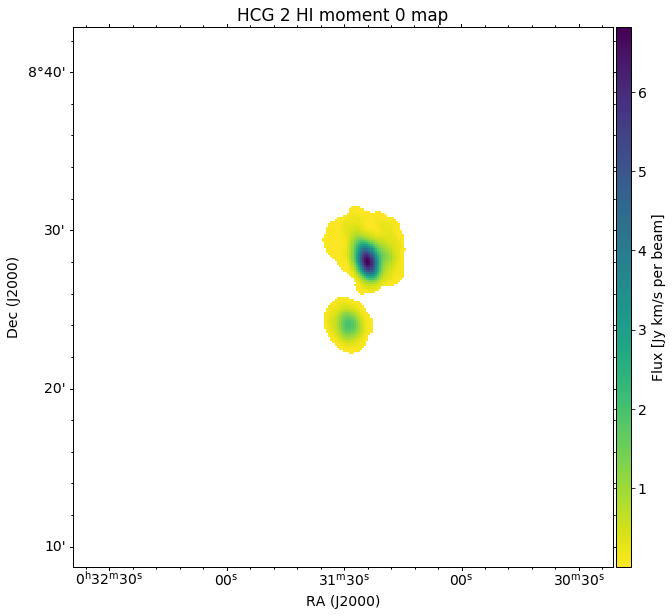

rms = 0.5956100067123771 mJy/beam
3-sigma n_HI = 0.07872756469234873 Msol/pc^2
3-sigma N_HI = 9.850801759217338e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


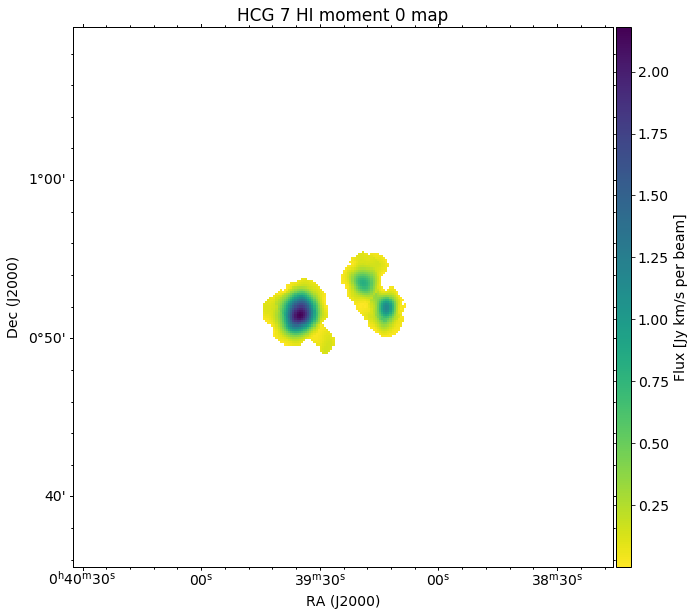

rms = 0.39176997961476445 mJy/beam
3-sigma n_HI = 0.07001505747697699 Msol/pc^2
3-sigma N_HI = 8.760647608764887e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


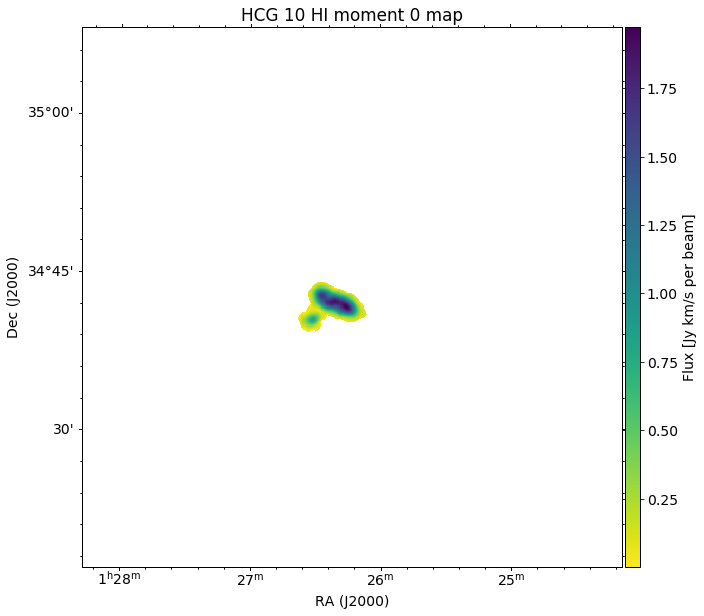

rms = 0.47895999159663916 mJy/beam
3-sigma n_HI = 0.09093943174297504 Msol/pc^2
3-sigma N_HI = 1.1378813985884488e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


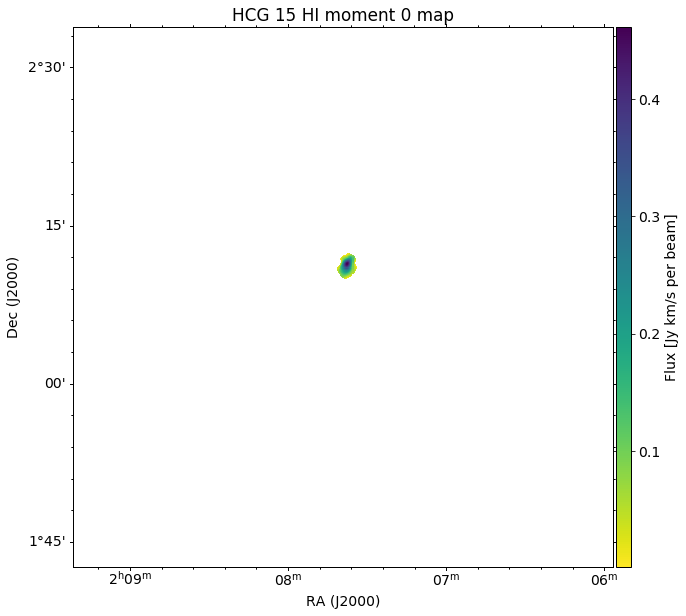

rms = 0.4096366853142778 mJy/beam
3-sigma n_HI = 0.1815417237776767 Msol/pc^2
3-sigma N_HI = 2.271544330056341e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


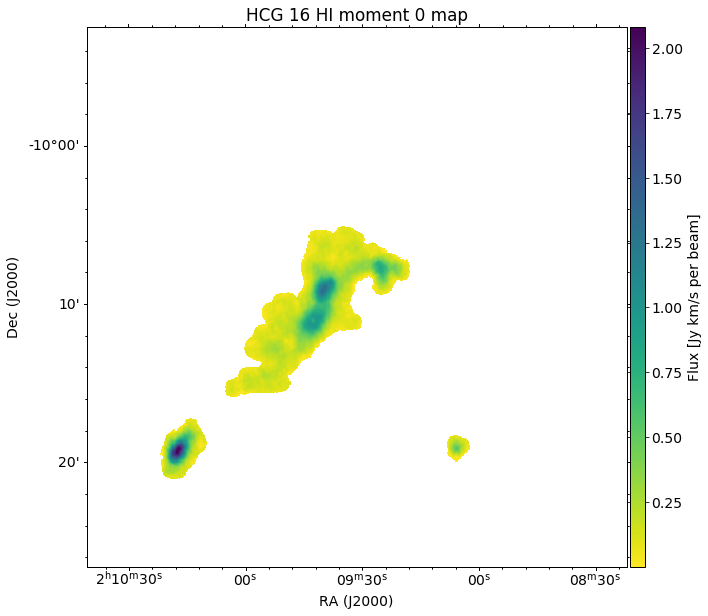

rms = 1.124766655266285 mJy/beam
3-sigma n_HI = 0.07456227944574062 Msol/pc^2
3-sigma N_HI = 9.3296196371071e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


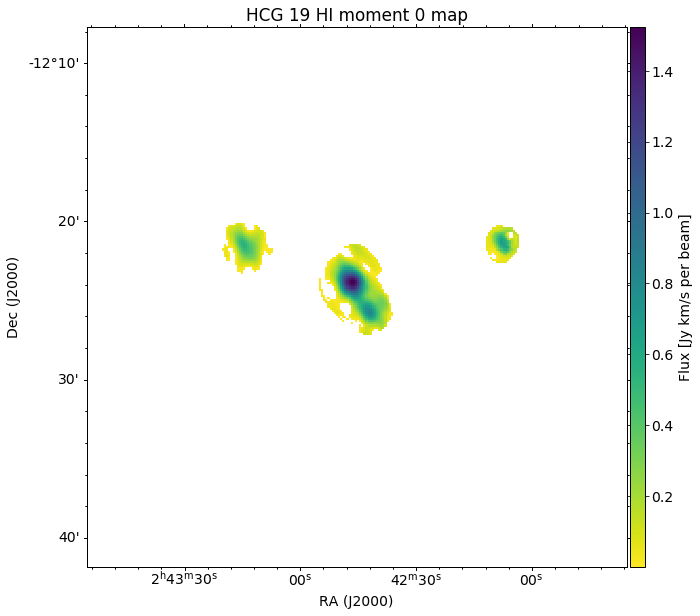

rms = 0.5612149834632874 mJy/beam
3-sigma n_HI = 0.1639182248847592 Msol/pc^2
3-sigma N_HI = 2.0510299592939127e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


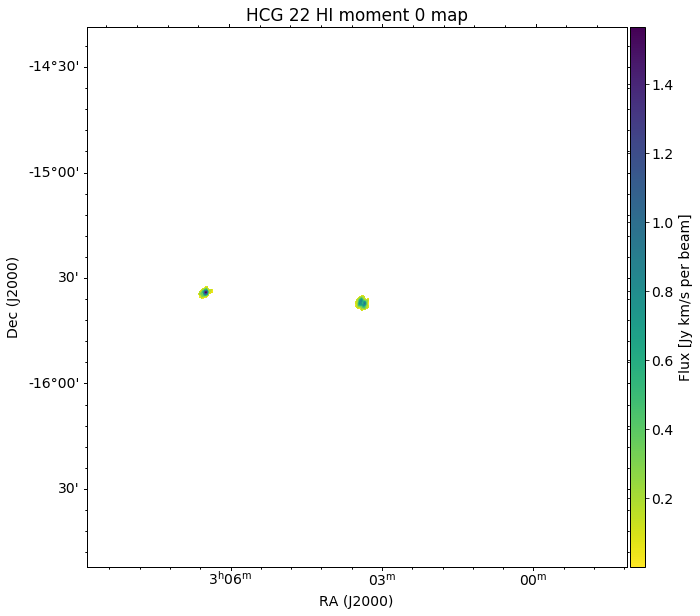

rms = 0.5633662804029882 mJy/beam
3-sigma n_HI = 0.6074980941991855 Msol/pc^2
3-sigma N_HI = 7.601331653588053e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


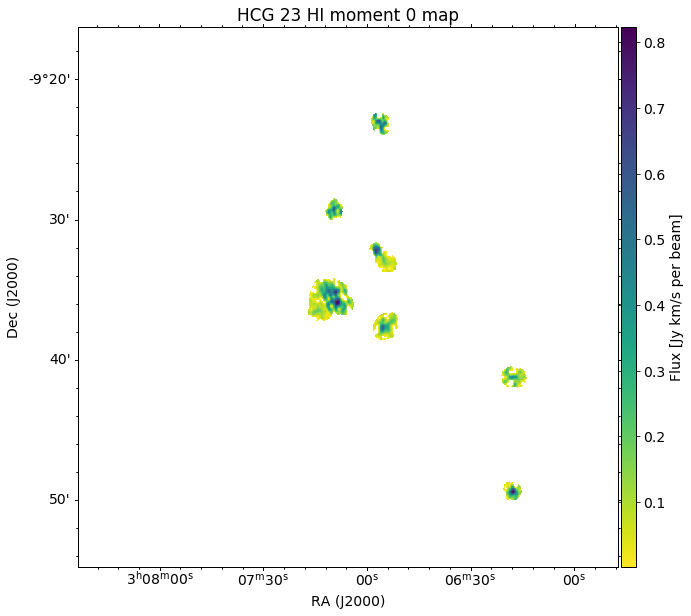

rms = 0.4952666349709034 mJy/beam
3-sigma n_HI = 0.07323718122093431 Msol/pc^2
3-sigma N_HI = 9.163816465434416e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


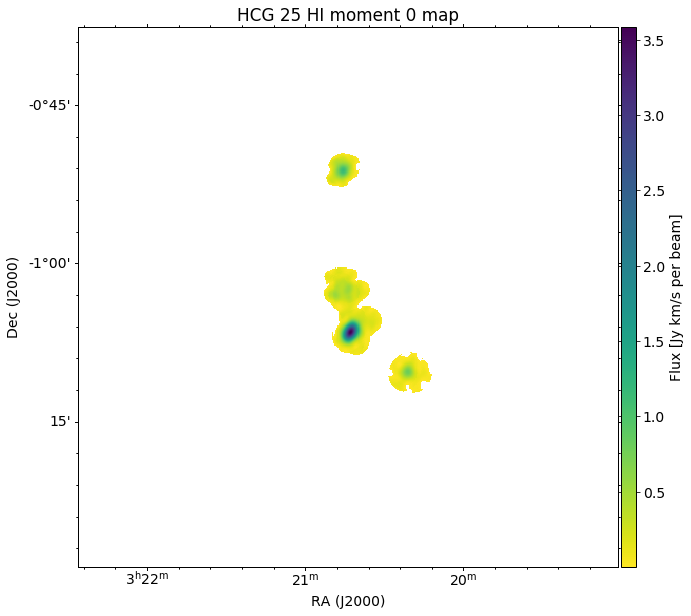

rms = 0.5213699769228697 mJy/beam
3-sigma n_HI = 0.3105797224411455 Msol/pc^2
3-sigma N_HI = 3.886134784120671e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


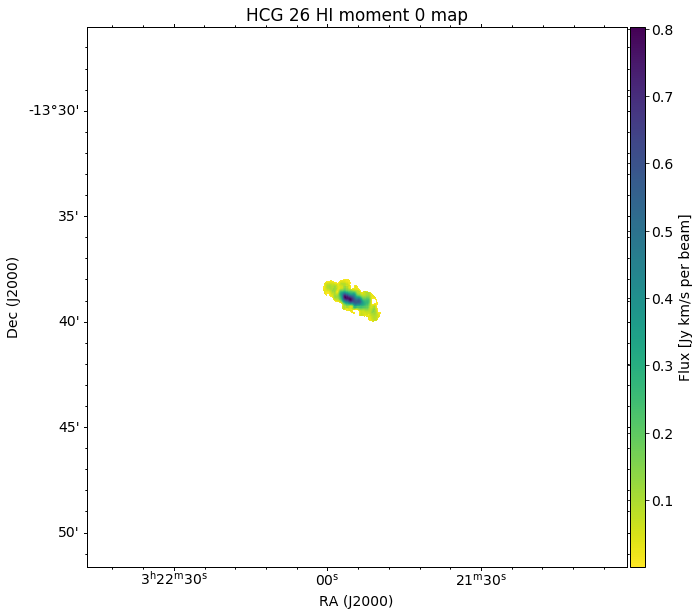

rms = 0.5120400339365005 mJy/beam
3-sigma n_HI = 0.10814255377050029 Msol/pc^2
3-sigma N_HI = 1.35313579569194e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


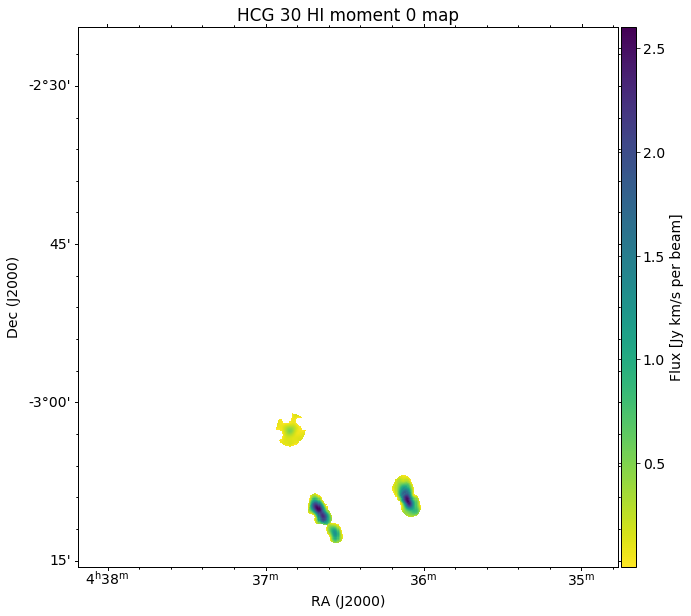

rms = 0.6463750032708049 mJy/beam
3-sigma n_HI = 1.0025827045821898 Msol/pc^2
3-sigma N_HI = 1.2544835482532014e+22 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


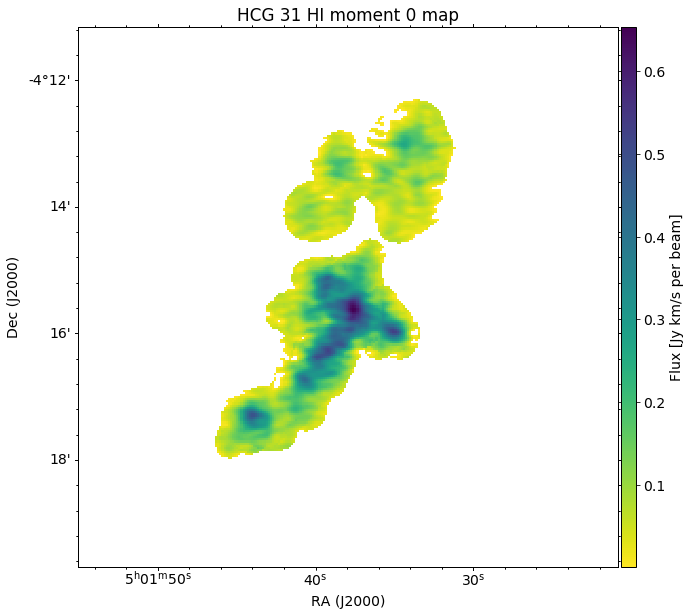

rms = 0.8215699926950037 mJy/beam
3-sigma n_HI = 1.6614933064547155 Msol/pc^2
3-sigma N_HI = 2.0789467132777445e+22 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


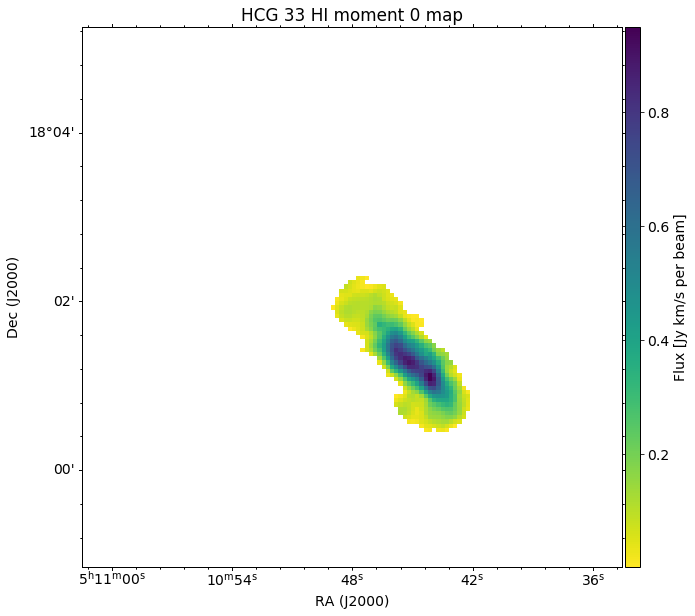

rms = 0.7440400077030063 mJy/beam
3-sigma n_HI = 0.17326226522512736 Msol/pc^2
3-sigma N_HI = 2.1679474447804693e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


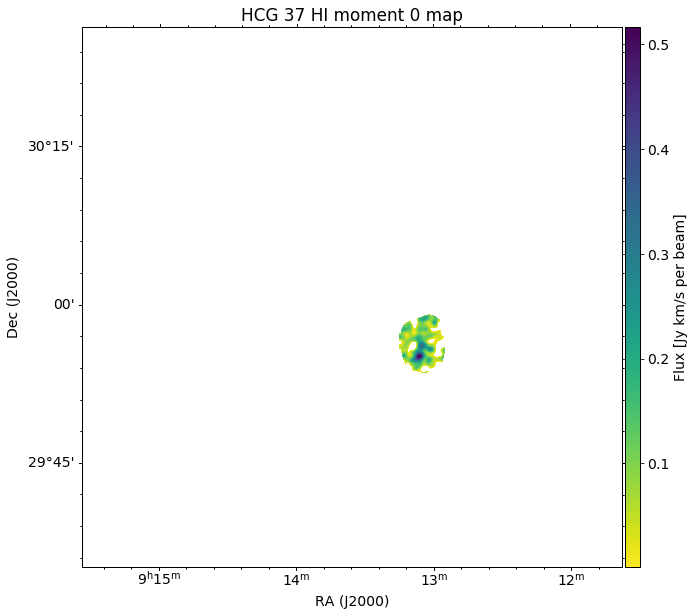

rms = 1.2387000024318695 mJy/beam
3-sigma n_HI = 0.032998850609699384 Msol/pc^2
3-sigma N_HI = 4.128987565009346e+20 cm^-2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


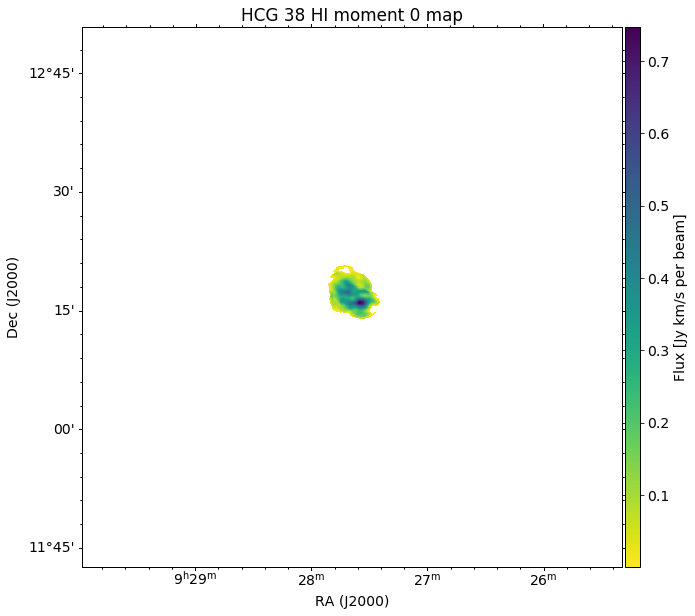

rms = 0.3296366970365246 mJy/beam
3-sigma n_HI = 0.06842687997810053 Msol/pc^2
3-sigma N_HI = 8.561926592040715e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


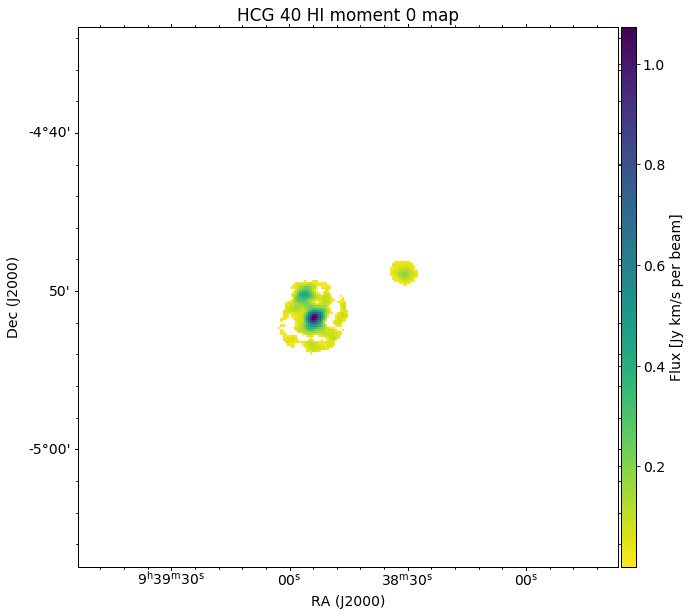

rms = 0.4885499947704375 mJy/beam
3-sigma n_HI = 0.10345429700451159 Msol/pc^2
3-sigma N_HI = 1.294473892229616e+21 cm^-2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


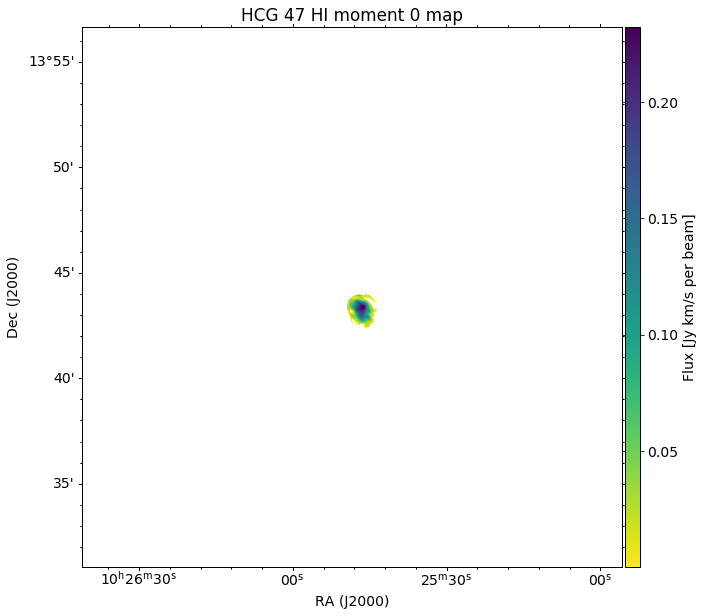

rms = 0.7821250474080443 mJy/beam
3-sigma n_HI = 0.2103289609788157 Msol/pc^2
3-sigma N_HI = 2.6317451923237686e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


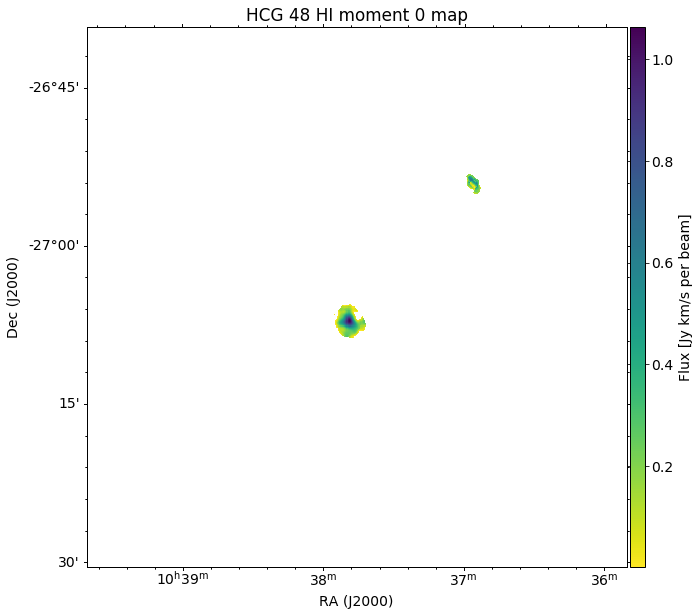

rms = 0.4025450034532696 mJy/beam
3-sigma n_HI = 0.06269683934888387 Msol/pc^2
3-sigma N_HI = 7.844954150034515e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


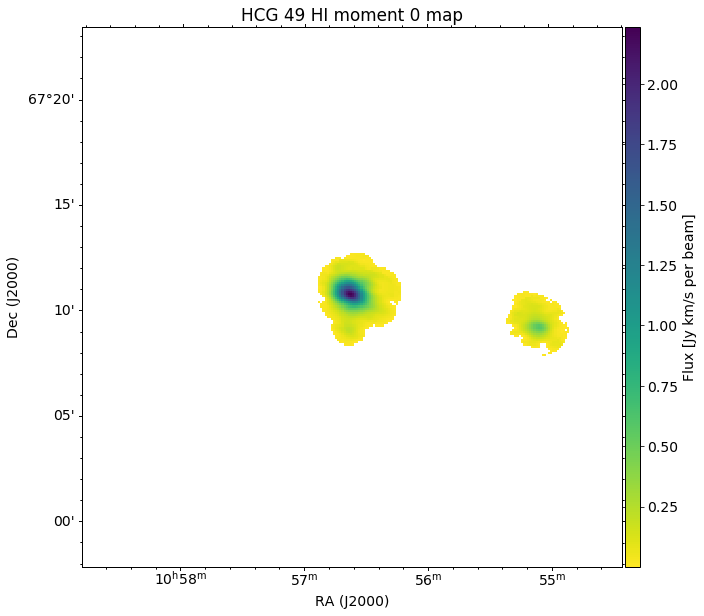

rms = 0.4534799954853952 mJy/beam
3-sigma n_HI = 0.3527488668119515 Msol/pc^2
3-sigma N_HI = 4.413777018674633e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


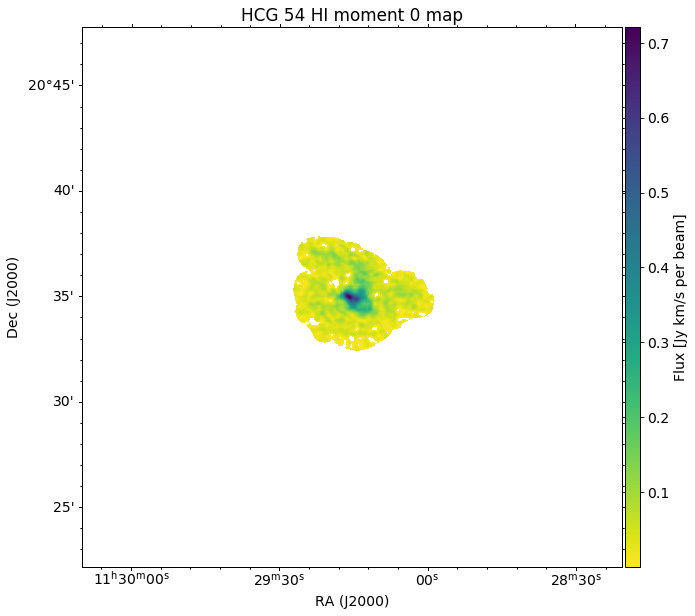

rms = 0.49086002400144935 mJy/beam
3-sigma n_HI = 0.139802445692778 Msol/pc^2
3-sigma N_HI = 1.7492808057190492e+21 cm^-2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


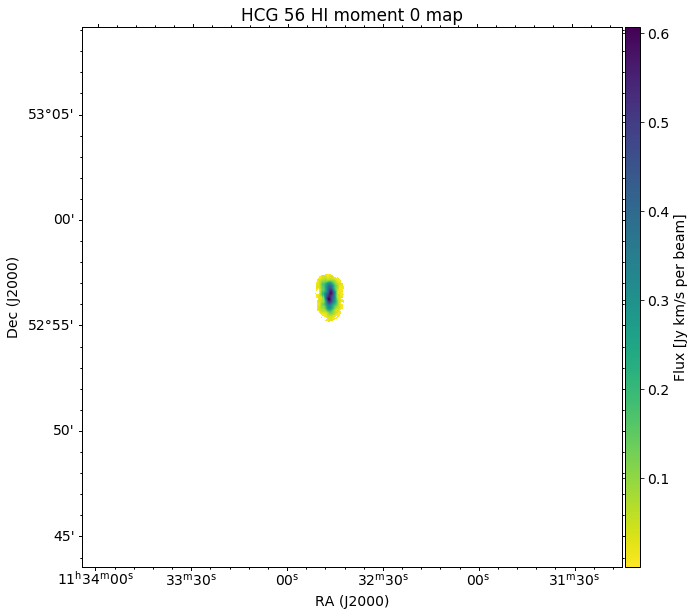

Mask, cube, or catalogue file not found for HCG 57.
rms = 0.24565666293104488 mJy/beam
3-sigma n_HI = 0.03586757241655847 Msol/pc^2
3-sigma N_HI = 4.487936935946246e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


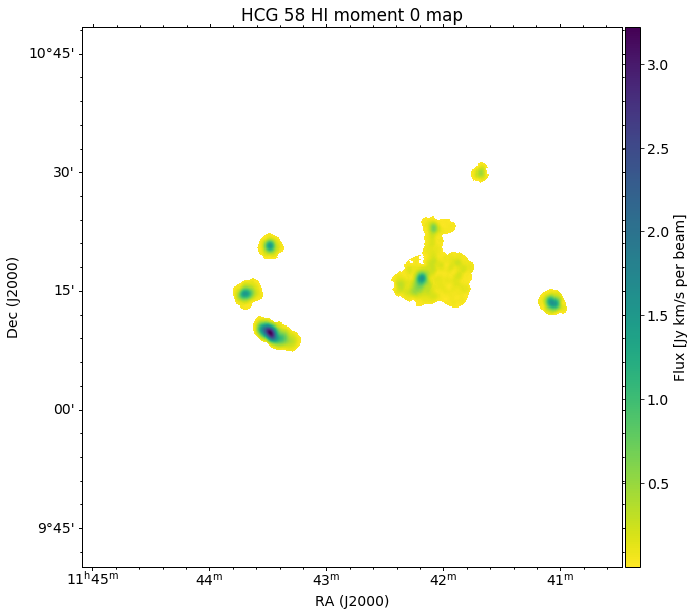

Mask, cube, or catalogue file not found for HCG 59.
rms = 0.3768799942918122 mJy/beam
3-sigma n_HI = 0.10032762570039258 Msol/pc^2
3-sigma N_HI = 1.2553513570623328e+21 cm^-2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


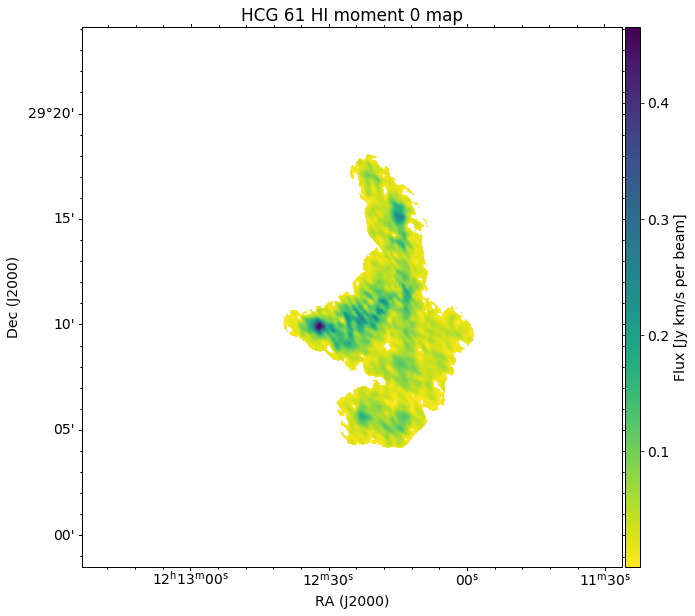

rms = 0.6215900066308677 mJy/beam
3-sigma n_HI = 0.22065352392378174 Msol/pc^2
3-sigma N_HI = 2.760931485865128e+21 cm^-2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


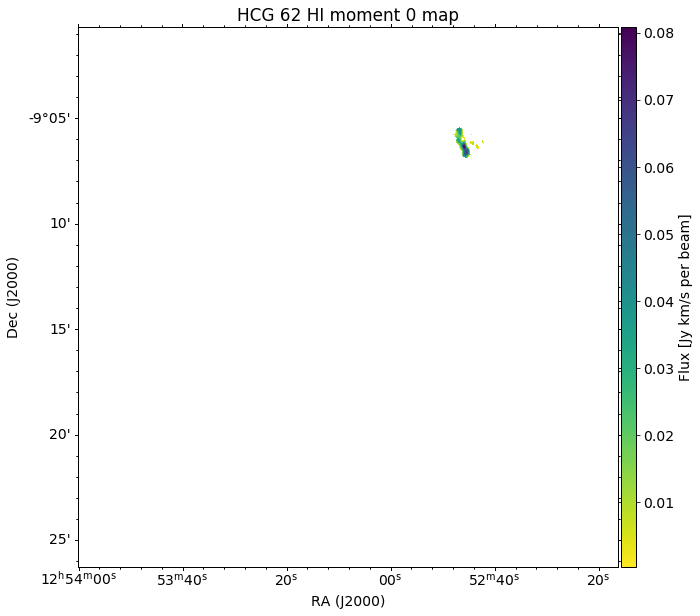

rms = 0.6829400081187487 mJy/beam
3-sigma n_HI = 0.058435354053508956 Msol/pc^2
3-sigma N_HI = 7.311734978215806e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


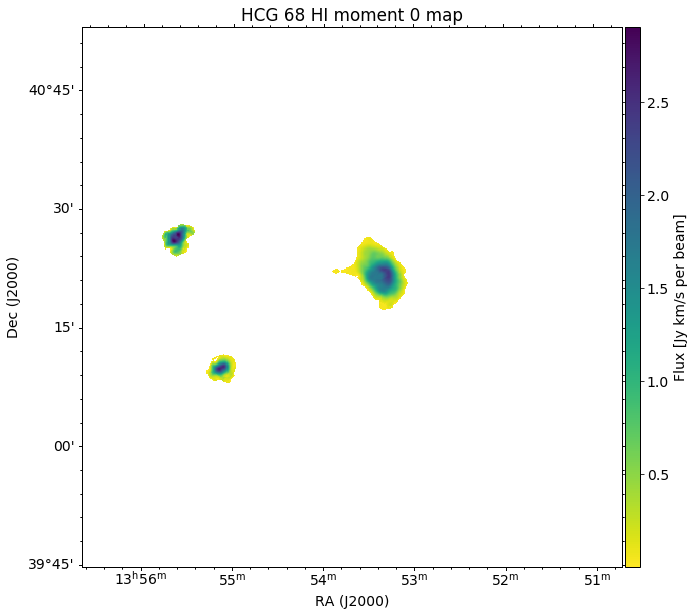

rms = 0.43518751044757664 mJy/beam
3-sigma n_HI = 0.1098774411699064 Msol/pc^2
3-sigma N_HI = 1.374843607832323e+21 cm^-2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


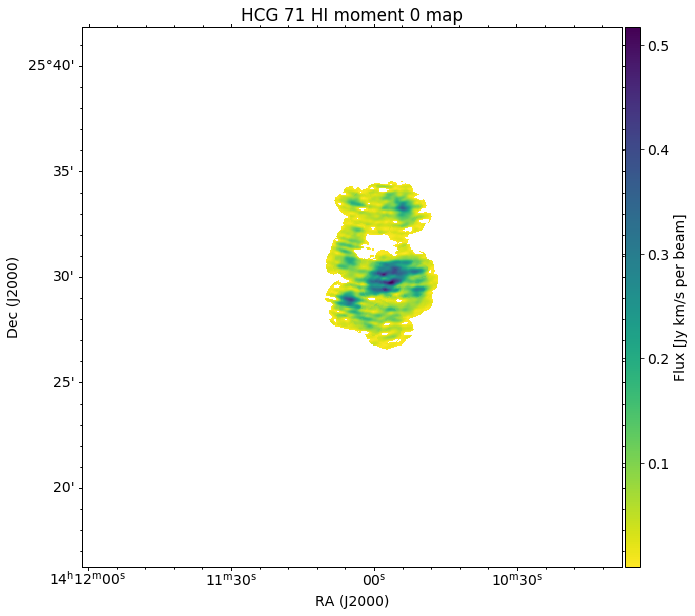

rms = 0.49538002349436283 mJy/beam
3-sigma n_HI = 0.37391599962655797 Msol/pc^2
3-sigma N_HI = 4.67863117742137e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


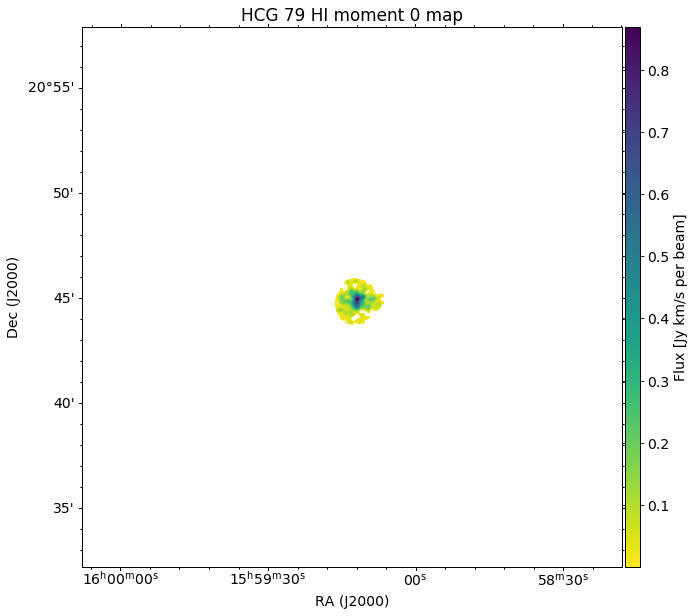

rms = 0.3019233311836918 mJy/beam
3-sigma n_HI = 0.42465053501048766 Msol/pc^2
3-sigma N_HI = 5.313448032694503e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


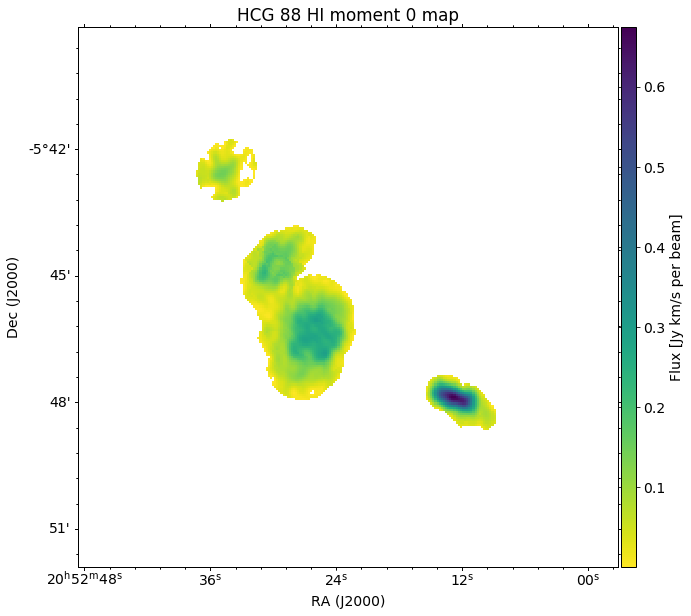

rms = 0.3533133227999012 mJy/beam
3-sigma n_HI = 0.49468441264337926 Msol/pc^2
3-sigma N_HI = 6.189748281135883e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


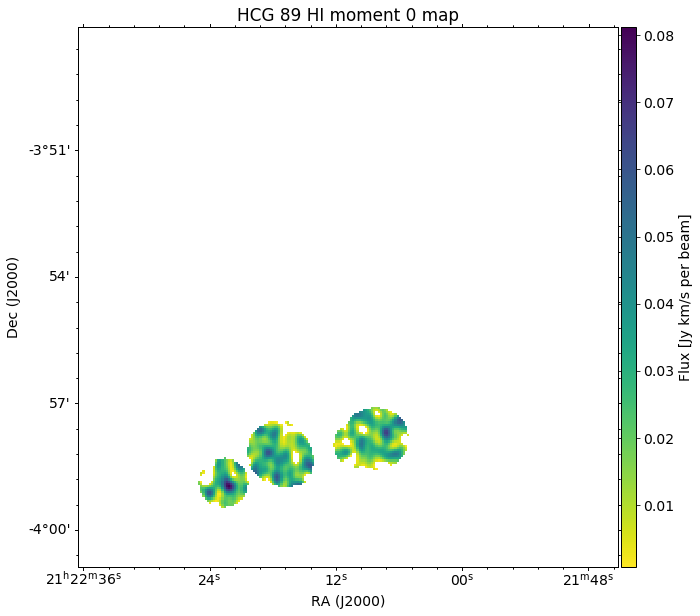

rms = 0.5221042915114334 mJy/beam
3-sigma n_HI = 0.2911964984521861 Msol/pc^2
3-sigma N_HI = 3.643601819058307e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


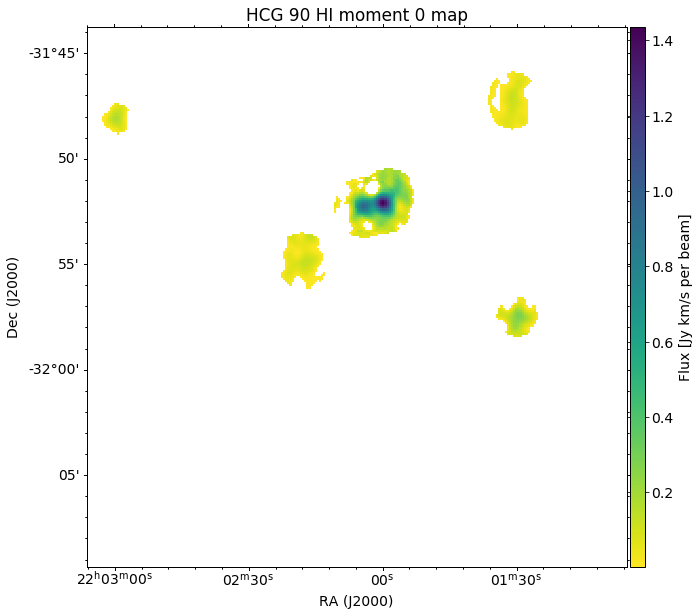

rms = 0.6596250459551811 mJy/beam
3-sigma n_HI = 0.1495046363335938 Msol/pc^2
3-sigma N_HI = 1.8706796537671188e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


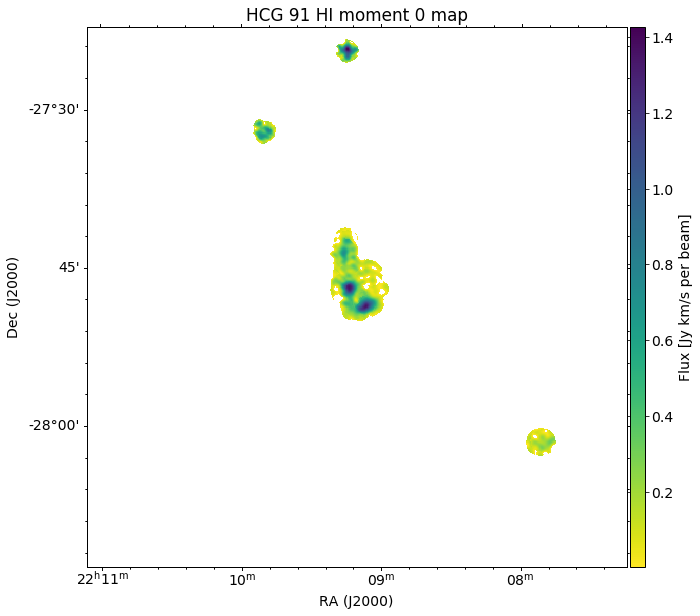

rms = 0.09379719849675894 mJy/beam
3-sigma n_HI = 1.3948009822968537 Msol/pc^2
3-sigma N_HI = 1.7452474268524212e+22 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


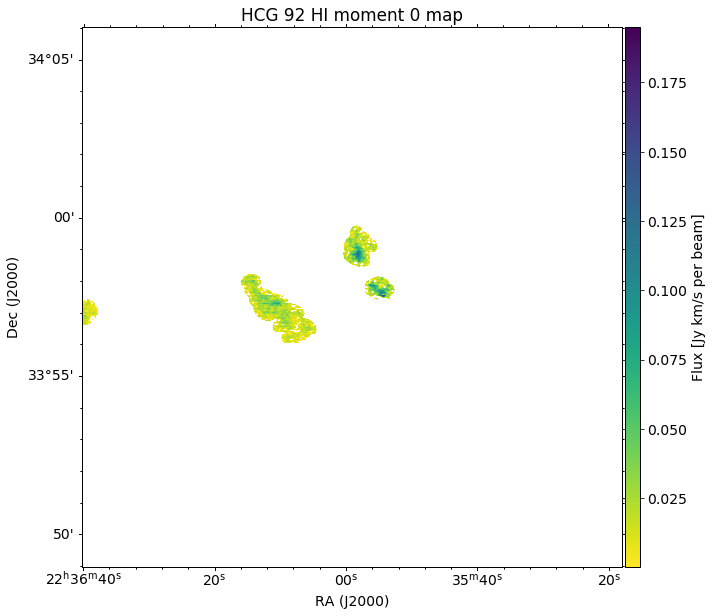

rms = 0.4015750018879771 mJy/beam
3-sigma n_HI = 0.06909352942269552 Msol/pc^2
3-sigma N_HI = 8.645341232735624e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


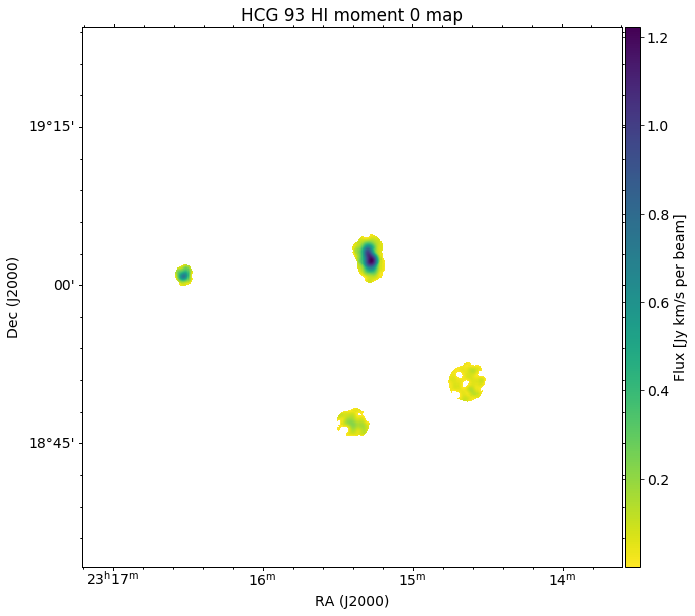

rms = 0.3216599967951576 mJy/beam
3-sigma n_HI = 0.4246520455229994 Msol/pc^2
3-sigma N_HI = 5.313466933011521e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


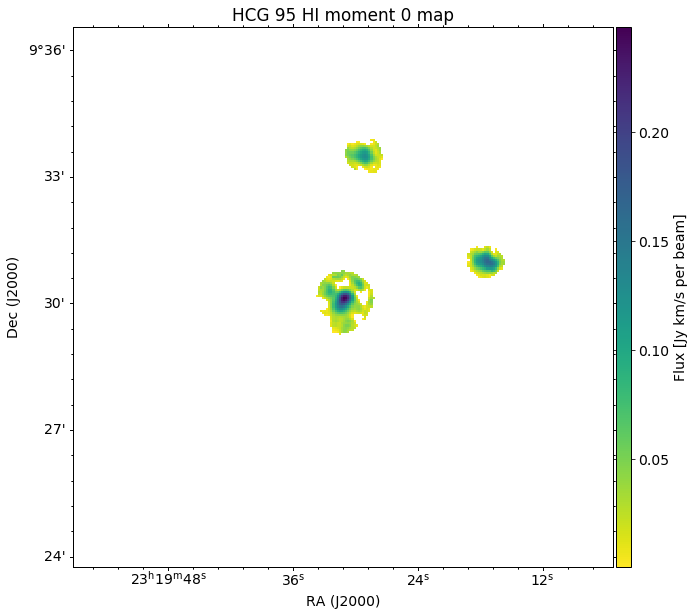

Mask, cube, or catalogue file not found for HCG 96.
rms = 0.4423274949658662 mJy/beam
3-sigma n_HI = 0.07727355706447908 Msol/pc^2
3-sigma N_HI = 9.668868773553348e+20 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


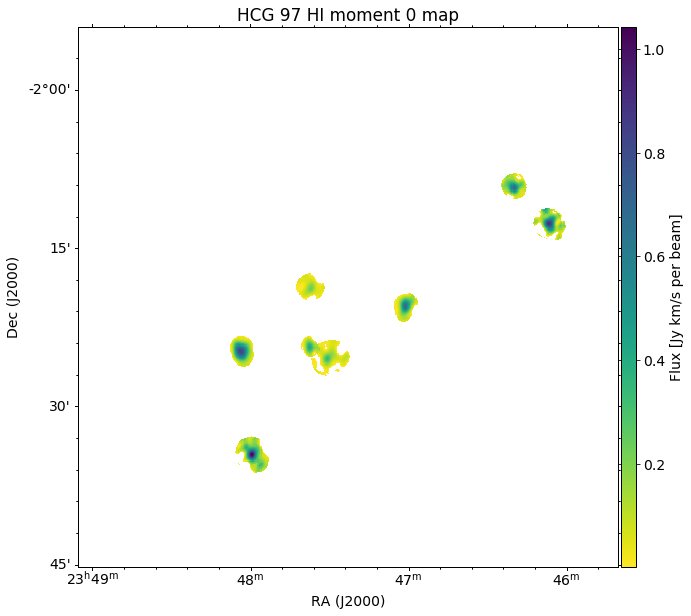

rms = 0.470989994937554 mJy/beam
3-sigma n_HI = 0.08687522094175537 Msol/pc^2
3-sigma N_HI = 1.0870278823302789e+21 cm^-2


Set OBSGEO-B to    34.078813 from OBSGEO-[XYZ].
Set OBSGEO-H to     2111.883 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


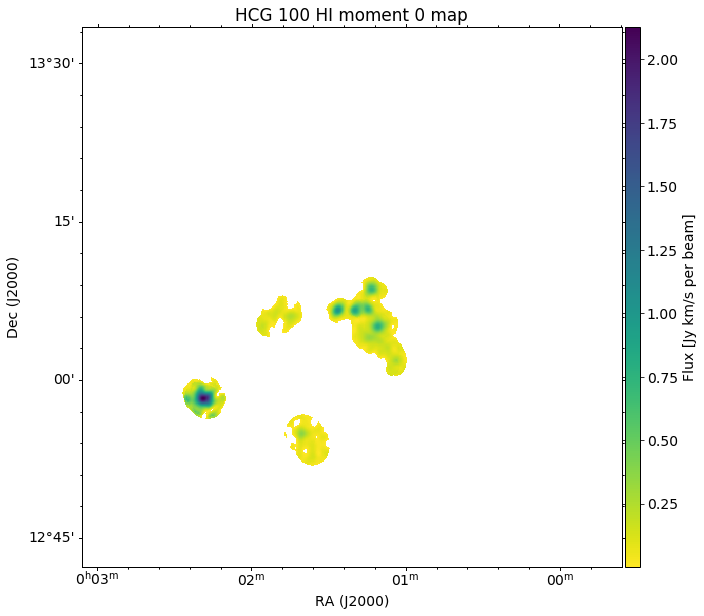

In [30]:
for HCG in HCGs['HCG']:
    mask = 'SoFiA_masks/HCG{0}/HCG{0}_mask.fits'.format(HCG)
    pbcube = 'SoFiA_masks/HCG{0}/HCG{0}_HI.pbcor.fits'.format(HCG)
    sofia_mom0 ='SoFiA_masks/HCG{0}/HCG{0}_mom0.fits'.format(HCG)
    src_cat = 'SoFiA_masks/HCG{0}/HCG{0}_cat.xml'.format(HCG)
    
    try:
        mask,mask_ra,mask_dec,mask_vel = read_fitscube(mask,mask=True)
        cube,cube_ra,cube_dec,cube_vel,bmaj,bmin,pa,beam_factor,cube_dx,cube_dy,cube_dv = read_fitscube(pbcube,True,True)
        src_cat = Table.read(src_cat)
    except FileNotFoundError:
        print("Mask, cube, or catalogue file not found for HCG {}.".format(HCG))
        continue
        
    rms = numpy.mean(src_cat['rms'])
    print("rms = {} mJy/beam".format(1000.*rms))
    n_HI = (rms*abs(cube_dv)*4.*numpy.log(2.)*2.356E-7)/(numpy.pi*bmaj*bmin*(numpy.pi/(180.*3600.))**2.)
    print("3-sigma n_HI = {} Msol/pc^2".format(3.*n_HI))
    N_HI = n_HI*Msol/(mp*(pc*10.)**2.)
    print("3-sigma N_HI = {} cm^-2".format(3.*N_HI))
        
    masked_cube = numpy.multiply(cube,mask)
    mom0 = numpy.nansum(masked_cube,axis=0)*abs(cube_dv)
    peak = max(mom0.flatten())
    
    hdu = fits.open(sofia_mom0)
    wcs = WCS(hdu[0].header,naxis=2)
    data = mom0
    hdu = fits.PrimaryHDU(data)
    hdu.header.update(wcs.to_header())
    
    fig = plt.figure(figsize=(10,10))
    mom0_fig = aplpy.FITSFigure(hdu,figure=fig)
    
    #Set colourbar and background colour
    viridis_cmap = plt.cm.viridis_r
    viridis_cmap.set_under(color='w')

    #Add beam ellipse
    #mom0_fig.add_beam()
    #mom0_fig.beam.set_color('k')
    #mom0_fig.beam.set_corner('bottom right')

    #Display the data with the chosen colour map
    mom0_fig.show_colorscale(cmap=viridis_cmap,vmin=rms*abs(cube_dv)/10.,vmax=peak,interpolation='none',stretch='linear')
    mom0_fig.set_title('HCG {0} HI moment 0 map'.format(HCG))
    
    #Make and label colourbar
    mom0_fig.add_colorbar()
    mom0_fig.colorbar.set_axis_label_text('Flux [Jy km/s per beam]')
    
    plt.show()